# Set OpenAI API Key

In [1]:
# Set OpenAI API key as environment variable
%env OPENAI_API_KEY=123456789

env: OPENAI_API_KEY=123456789


# Import Libraries

## Core Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # For saving tokenizer

## NLTK for Text Processing

In [3]:
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Embeddings for Words

In [4]:
# import os
# if not os.path.exists('glove.6B.zip'):
#     # Download the GloVe 6B embeddings (822MB)
#     !wget http://nlp.stanford.edu/data/glove.6B.zip
#     # Unzip the file
#     !unzip glove.6B.zip

## Scikit-learn for Splitting and Metrics

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## TensorFlow and Keras for Deep Learning

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## KerasTuner for Hyperparameter Optimization

In [7]:
!pip install keras-tuner -q # Uncomment and run once if not installed
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [27]:
from google.colab import files

# Datasets and Preprocessing

## Uploading Datasets

In [53]:
PATH_ISOT_FAKE = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/ISOT/Fake.csv' # e.g., 'data/ISOT/Fake.csv'
PATH_ISOT_TRUE = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/ISOT/True.csv' # e.g., 'data/ISOT/True.csv'
PATH_WELFAKE = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/Phase_4.csv' # e.g., 'data/WELFake/WELFake_Dataset.csv'
PATH_LIAR_TRAIN = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/LIAR/train.tsv' # e.g., 'data/LIAR/train.tsv'

## Data Loading and Initial Preprocessing

In [54]:
def standardize_label_isot_welfake(label):
    try:
        label_int = int(label)
        if label_int == 0: return 0 # Fake
        if label_int == 1: return 1 # Real
    except:
        pass # Handle non-integer labels if any
    return None # For unmappable labels

In [55]:
def standardize_label_liar(label_str):
    label_str = str(label_str).lower()
    if label_str in ['false', 'pants-fire', 'pants on fire', 'mostly-false']:
        return 0 # Fake
    elif label_str in ['true', 'mostly-true', 'half-true']: # half-true is debatable, adjust as needed
        return 1 # Real
    return None # For 'barely-true' or other nuanced labels you might exclude or map differently

In [56]:
dataframes = []

### Load ISOT Dataset

In [57]:
try:
    df_fake_isot = pd.read_csv(PATH_ISOT_FAKE)
    df_true_isot = pd.read_csv(PATH_ISOT_TRUE)
    df_fake_isot['label_orig'] = 0 # Mark as fake
    df_true_isot['label_orig'] = 1 # Mark as real
    df_isot = pd.concat([df_fake_isot, df_true_isot], ignore_index=True)
    df_isot.rename(columns={'text': 'text_col', 'title': 'title_col'}, inplace=True) # Avoid name clashes
    df_isot['label'] = df_isot['label_orig'].apply(standardize_label_isot_welfake)
    df_isot = df_isot[['title_col', 'text_col', 'label']].copy()
    df_isot.dropna(subset=['title_col', 'text_col', 'label'], inplace=True)
    df_isot['label'] = df_isot['label'].astype(int)
    dataframes.append(df_isot)
    print(f"ISOT dataset loaded: {len(df_isot)} samples.")
except FileNotFoundError:
    print(f"Warning: ISOT dataset files not found at {PATH_ISOT_FAKE} or {PATH_ISOT_TRUE}.")
except Exception as e:
    print(f"Error loading ISOT dataset: {e}")

ISOT dataset loaded: 44898 samples.


### Load WELFake Dataset

In [58]:
try:
    df_welfake = pd.read_csv(PATH_WELFAKE)
    # WELFake often has an unnamed index column
    if 'Unnamed: 0' in df_welfake.columns:
        df_welfake.drop('Unnamed: 0', axis=1, inplace=True)
    df_welfake.rename(columns={'text': 'text_col', 'title': 'title_col', 'label': 'label_orig'}, inplace=True)
    df_welfake['label'] = df_welfake['label_orig'].apply(standardize_label_isot_welfake)
    df_welfake = df_welfake[['title_col', 'text_col', 'label']].copy()
    df_welfake.dropna(subset=['title_col', 'text_col', 'label'], inplace=True)
    df_welfake['label'] = df_welfake['label'].astype(int)
    dataframes.append(df_welfake)
    print(f"WELFake dataset loaded: {len(df_welfake)} samples.")
except FileNotFoundError:
    print(f"Warning: WELFake dataset file not found at {PATH_WELFAKE}.")
except Exception as e:
    print(f"Error loading WELFake dataset: {e}")

WELFake dataset loaded: 71537 samples.


### Load LIAR Dataset

In [59]:
try:
    # LIAR columns: ID, Label, Statement, Subject(s), Speaker, Speaker's Job, State, Party,
    # Barely true, False, Half true, Mostly true, Pants on fire, Context
    df_liar_train = pd.read_csv(PATH_LIAR_TRAIN, sep='\t', header=None,
                                names=['id', 'label_liar', 'statement', 'subject', 'speaker', 'job_title',
                                       'state_info', 'party_affiliation', 'bt_counts', 'f_counts',
                                       'ht_counts', 'mt_counts', 'pof_counts', 'context'])
    df_liar_train.rename(columns={'statement': 'text_col', 'subject': 'title_col', 'label_liar':'label_orig'}, inplace=True)
    df_liar_train['label'] = df_liar_train['label_orig'].apply(standardize_label_liar)
    df_liar_train = df_liar_train[['title_col', 'text_col', 'label']].copy()
    df_liar_train['title_col'] = df_liar_train['title_col'].fillna('') # Titles can be sparse
    df_liar_train.dropna(subset=['text_col', 'label'], inplace=True)
    df_liar_train['label'] = df_liar_train['label'].astype(int)
    dataframes.append(df_liar_train)
    print(f"LIAR train dataset loaded: {len(df_liar_train)} samples.")
except FileNotFoundError:
    print(f"Warning: LIAR dataset file not found at {PATH_LIAR_TRAIN}.")
except Exception as e:
    print(f"Error loading LIAR dataset: {e}")

LIAR train dataset loaded: 8586 samples.


### Invalid Datasets

In [60]:
if not dataframes:
    raise SystemExit("No datasets were loaded. Please check paths and ensure at least one dataset is available.")

### Merge all Datasets

In [61]:
merged_df = pd.concat(dataframes, ignore_index=True)
print(f"Total samples after merging: {len(merged_df)}")

Total samples after merging: 125021


#### Download the Combined Dataset

In [28]:
# # Shuffle the merged dataset
# merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # Define the output path for the shuffled dataset
# output_path = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/shuffled_merged_dataset.csv'

# # Save the shuffled dataset to a CSV file
# merged_df.to_csv(output_path, index=False)

# print(f"Shuffled dataset saved to {output_path}")

# # Download the shuffled CSV file
# files.download(output_path)
# print(f"Shuffled dataset downloaded.")

Shuffled dataset saved to /content/drive/MyDrive/Fake_News_Detection_Project/Datasets/shuffled_merged_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Shuffled dataset downloaded.


### Combine Title and Text

In [62]:
merged_df['full_text'] = merged_df['title_col'].astype(str) + " " + merged_df['text_col'].astype(str)
merged_df = merged_df[['full_text', 'label']]
merged_df.dropna(inplace=True) # Just in case
merged_df.drop_duplicates(subset=['full_text'], inplace=True) # Remove duplicate articles
print(f"Total samples after combining text and removing duplicates: {len(merged_df)}")

Total samples after combining text and removing duplicates: 71698


<ipython-input-62-2190887902>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.dropna(inplace=True) # Just in case
<ipython-input-62-2190887902>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop_duplicates(subset=['full_text'], inplace=True) # Remove duplicate articles


### Shuffle the Dataset

In [63]:
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [64]:
print("Label distribution in merged dataset:")
print(merged_df['label'].value_counts(normalize=True))

Label distribution in merged dataset:
label
1    0.521186
0    0.478814
Name: proportion, dtype: float64


# Advanced Text Processing

In [65]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [66]:
def preprocess_text_data(text):
    text = str(text).lower() # Ensure text is string and lowercase
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()] # Keep only alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [67]:
print("\nStarting text preprocessing...")
merged_df['processed_text'] = merged_df['full_text'].apply(preprocess_text_data)
print("Text preprocessing complete.")
print(merged_df[['full_text', 'processed_text', 'label']].head())


Starting text preprocessing...
Text preprocessing complete.
                                           full_text  \
0  Friday Mailbag: When the President Attacks - T...   
1  The Geopolitics of Russia-Egypt Relations Leav...   
2  Tony Award Winners - The New York Times  Our c...   
3  Hillary's Hypocrisy On Sexual Assault BRUTALLY...   
4  education Says she was the first in her family...   

                                      processed_text  label  
0  friday mailbag president attack new york time ...      0  
1  geopolitics russiaegypt relation leave reply c...      1  
2  tony award winner new york time complete cover...      0  
3  hillary hypocrisy sexual assault brutally expo...      1  
4     education say first family go fouryear college      0  


# Word Embeddings

## Upload GloVe

In [68]:
GLOVE_FILE_PATH = '/content/drive/MyDrive/Fake_News_Detection_Project/Datasets/glove.6B.100d.txt' # e.g., 'embeddings/glove.6B.100d.txt'

## Vectorization

In [69]:
MAX_NUM_WORDS = 50000  # Max words in vocabulary
MAX_SEQUENCE_LENGTH = 300 # Max length of sequences (tune this based on your data analysis)
EMBEDDING_DIM = 100    # Dimension of GloVe embeddings used (must match your GloVe file)

In [70]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<oov>")
tokenizer.fit_on_texts(merged_df['processed_text'])
word_index = tokenizer.word_index

### Save the tokenizer

In [71]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Tokenizer saved to tokenizer.pickle. Vocabulary size: {len(word_index)}")

Tokenizer saved to tokenizer.pickle. Vocabulary size: 324752


## Create Embedding Matrix from GloVe

In [72]:
sequences = tokenizer.texts_to_sequences(merged_df['processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [73]:
labels_final = merged_df['label'].values

In [74]:
print("\nLoading GloVe embeddings...")
embeddings_index = {}
try:
    with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors in GloVe.")

    embedding_matrix = np.zeros((min(MAX_NUM_WORDS, len(word_index) + 1), EMBEDDING_DIM))
    num_words_in_glove = 0
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            num_words_in_glove +=1
    print(f"Embedding matrix created. {num_words_in_glove}/{min(MAX_NUM_WORDS, len(word_index) + 1)} words found in GloVe.")

except FileNotFoundError:
    print(f"GloVe file not found at {GLOVE_FILE_PATH}. Embedding layer will be initialized randomly if trainable.")
    embedding_matrix = None # Will be handled in model building
except Exception as e:
    print(f"Error loading GloVe: {e}")
    embedding_matrix = None


Loading GloVe embeddings...
Found 400000 word vectors in GloVe.
Embedding matrix created. 42566/50000 words found in GloVe.


# Split Data

In [75]:
# Split into training + validation and a final hold-out test set
X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    padded_sequences, labels_final, test_size=0.20, random_state=42, stratify=labels_final # 20% for final test
)

In [76]:
# Split training+validation into actual training and validation for KerasTuner
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val # 15% of (80%) for validation
)

In [77]:
print(f"\nData shapes:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test_final shape: {X_test_final.shape}, y_test_final shape: {y_test_final.shape}")


Data shapes:
X_train shape: (48754, 300), y_train shape: (48754,)
X_val shape: (8604, 300), y_val shape: (8604,)
X_test_final shape: (14340, 300), y_test_final shape: (14340,)


# Hyperparameter Tuning with KerasTuner

In [78]:
def build_bilstm_model(hp):
    model = Sequential()

    # Embedding Layer
    use_pretrained_embedding = (embedding_matrix is not None)
    is_embedding_trainable = hp.Boolean("embedding_trainable", default=False if use_pretrained_embedding else True)

    if use_pretrained_embedding:
        model.add(Embedding(
            input_dim=min(MAX_NUM_WORDS, len(word_index) + 1),
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=is_embedding_trainable
        ))
    else: # No GloVe, learn embeddings from scratch
         model.add(Embedding(
            input_dim=min(MAX_NUM_WORDS, len(word_index) + 1),
            output_dim=hp.Int("embedding_dim_scratch", min_value=50, max_value=200, step=50), # Tune embedding dim if from scratch
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True # Must be trainable if from scratch
        ))

    model.add(SpatialDropout1D(hp.Float("spatial_dropout", min_value=0.1, max_value=0.4, step=0.1)))

    # BiLSTM Layers
    num_lstm_layers = hp.Int("num_lstm_layers", min_value=1, max_value=2, step=1)
    for i in range(num_lstm_layers):
        model.add(Bidirectional(LSTM(
            units=hp.Int(f"lstm_{i}_units", min_value=32, max_value=128, step=32),
            return_sequences= (i < num_lstm_layers - 1), # True for all but last LSTM layer
            dropout=hp.Float(f"lstm_{i}_dropout", min_value=0.1, max_value=0.4, step=0.1),
            recurrent_dropout=hp.Float(f"lstm_{i}_recurrent_dropout", min_value=0.1, max_value=0.4, step=0.1)
        )))

    # Dense Layers
    model.add(Dense(
        units=hp.Int("dense_units", min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float("dense_dropout", min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [104]:
# Instantiate the tuner
# Using Hyperband for potentially faster search than RandomSearch
tuner = kt.Hyperband( # Or kt.RandomSearch
    build_bilstm_model,
    objective='val_accuracy',
    max_epochs=5,          # Max epochs to train a model for during hyperband rounds
    factor=3,               # Reduction factor for Hyperband
    hyperband_iterations=1, # How many times to run Hyperband, can increase for more thorough search
    directory='keras_tuner_bilstm_dir',
    project_name='fake_news_detection',
    seed=42,
    overwrite=True # Set to False to resume a previous search
)

print("\nStarting hyperparameter search with KerasTuner...")
tuner.search_space_summary()


Starting hyperparameter search with KerasTuner...
Search space summary
Default search space size: 9
embedding_trainable (Boolean)
{'default': False, 'conditions': []}
spatial_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
num_lstm_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
lstm_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_0_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
lstm_0_recurrent_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [101]:
# Early stopping for the tuner search itself, to speed up individual trials
tuner_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [102]:
# Reduce batch size for tuning if memory is an issue, or use a default
TUNER_BATCH_SIZE = 64

In [103]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             callbacks=[tuner_early_stopping],
             batch_size=TUNER_BATCH_SIZE
            )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |True              |embedding_trainable
0.1               |0.1               |spatial_dropout
1                 |1                 |num_lstm_layers
64                |64                |lstm_0_units
0.4               |0.4               |lstm_0_dropout
0.2               |0.2               |lstm_0_recurrent_dropout
96                |96                |dense_units
0.2               |0.2               |dense_dropout
0.00098872        |0.00098872        |learning_rate
1                 |1                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


 40/762 ━━━━━━━━━━━━━━━━━━━━ 15:35 1s/step - accuracy: 0.5707 - loss: 0.6761

KeyboardInterrupt: 

## Optimal Hyperparameters

In [83]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [84]:
print("\n--- Optimal Hyperparameters Found ---")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


--- Optimal Hyperparameters Found ---
embedding_trainable: True
spatial_dropout: 0.1
num_lstm_layers: 1
lstm_0_units: 64
lstm_0_dropout: 0.4
lstm_0_recurrent_dropout: 0.2
dense_units: 96
dense_dropout: 0.2
learning_rate: 0.0009887195863122636
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0


In [85]:
# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,000 (19.07 MB)

 Trainable params: 5,000,000 (19.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Best Model

In [89]:
print("\nTraining the best model with optimal hyperparameters...")

FINAL_EPOCHS = 2 # Train for more epochs now
FINAL_BATCH_SIZE = best_hps.get('batch_size') if 'batch_size' in best_hps.values else 64 # Or use a fixed one like 64

final_early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)
final_model_checkpoint = ModelCheckpoint('best_bilstm_tuned_model.keras', # Use .keras for new Keras format
                                         save_best_only=True,
                                         monitor='val_accuracy',
                                         mode='max',
                                         verbose=1)

history = best_model.fit(
    X_train, y_train, # Or X_train_val, y_train_val for final model training
    epochs=FINAL_EPOCHS,
    batch_size=FINAL_BATCH_SIZE,
    validation_data=(X_val, y_val), # Or a new split if you used X_train_val above
    callbacks=[final_early_stopping, final_model_checkpoint]
)


Training the best model with optimal hyperparameters...
Epoch 1/2
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8136 - loss: 0.3920
Epoch 1: val_accuracy improved from -inf to 0.91062, saving model to best_bilstm_tuned_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 1023s 1s/step - accuracy: 0.8136 - loss: 0.3919 - val_accuracy: 0.9106 - val_loss: 0.2124
Epoch 2/2
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9048 - loss: 0.2199
Epoch 2: val_accuracy improved from 0.91062 to 0.92190, saving model to best_bilstm_tuned_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 1023s 1s/step - accuracy: 0.9048 - loss: 0.2199 - val_accuracy: 0.9219 - val_loss: 0.1877
Restoring model weights from the end of the best epoch: 2.


In [90]:
# Load the best model explicitly (ModelCheckpoint should have saved the best one)
best_model_loaded = load_model('best_bilstm_tuned_model.keras')
print("Best tuned model loaded from best_bilstm_tuned_model.keras")

Best tuned model loaded from best_bilstm_tuned_model.keras


## Save the Best Model

In [91]:
model_path = '/content/drive/MyDrive/Fake_News_Detection_Project/Saved_models/best_bilstm_tuned_model.pkl' # Use .pkl extension for pickle
with open(model_path, 'wb') as f:
    pickle.dump(best_model_loaded, f)

print(f"Best model saved to {model_path} in pickle format.")

Best model saved to /content/drive/MyDrive/Fake_News_Detection_Project/Saved_models/best_bilstm_tuned_model.pkl in pickle format.


# Final Evaluation

In [92]:
def evaluate_model(model, X_data, y_data, data_name="Test"):
    loss, accuracy = model.evaluate(X_data, y_data, verbose=0)
    print(f"\n--- Evaluation on {data_name} Data ---")
    print(f"{data_name} Accuracy: {accuracy*100:.2f}%")
    print(f"{data_name} Loss: {loss:.4f}")

    y_pred_probs = model.predict(X_data)
    y_pred_classes = (y_pred_probs > 0.5).astype("int32")

    print(f"\nClassification Report ({data_name} Data):")
    print(classification_report(y_data, y_pred_classes, target_names=['Fake (0)', 'Real (1)']))

    print(f"\nConfusion Matrix ({data_name} Data):")
    cm = confusion_matrix(y_data, y_pred_classes)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {data_name} Set')
    plt.show()
    return accuracy, loss

## Evaluate on Training data


--- Evaluation on Training Data ---
Training Accuracy: 93.02%
Training Loss: 0.1577
1524/1524 ━━━━━━━━━━━━━━━━━━━━ 377s 247ms/step

Classification Report (Training Data):
              precision    recall  f1-score   support

    Fake (0)       0.94      0.91      0.93     23344
    Real (1)       0.92      0.95      0.93     25410

    accuracy                           0.93     48754
   macro avg       0.93      0.93      0.93     48754
weighted avg       0.93      0.93      0.93     48754


Confusion Matrix (Training Data):


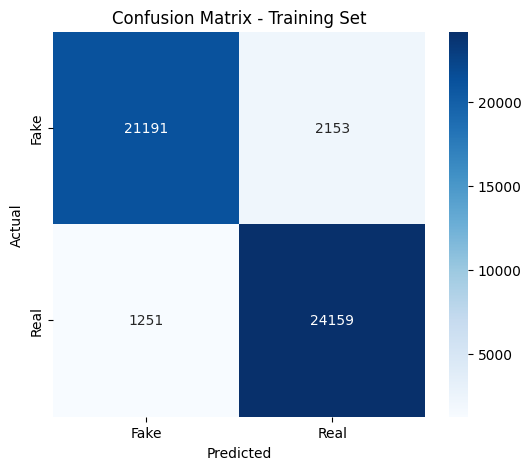

In [93]:
train_acc, train_loss = evaluate_model(best_model_loaded, X_train, y_train, "Training")

## Evaluate on Validation data


--- Evaluation on Validation Data ---
Validation Accuracy: 92.19%
Validation Loss: 0.1877
269/269 ━━━━━━━━━━━━━━━━━━━━ 66s 246ms/step

Classification Report (Validation Data):
              precision    recall  f1-score   support

    Fake (0)       0.93      0.91      0.92      4120
    Real (1)       0.92      0.94      0.93      4484

    accuracy                           0.92      8604
   macro avg       0.92      0.92      0.92      8604
weighted avg       0.92      0.92      0.92      8604


Confusion Matrix (Validation Data):


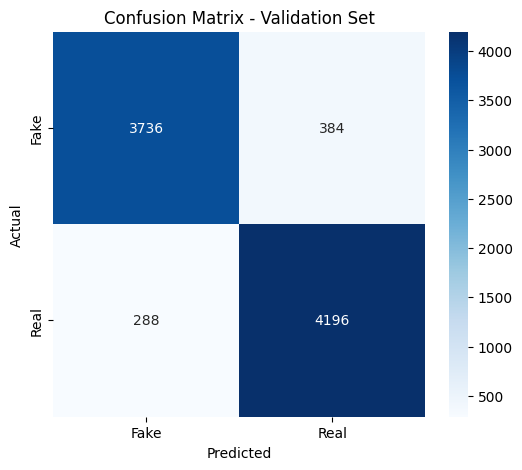

In [94]:
val_acc, val_loss = evaluate_model(best_model_loaded, X_val, y_val, "Validation")

## Evaluate on the FINAL, UNSEEN Test Set


--- Evaluation on Final Unseen Test Data ---
Final Unseen Test Accuracy: 91.81%
Final Unseen Test Loss: 0.1953
449/449 ━━━━━━━━━━━━━━━━━━━━ 111s 246ms/step

Classification Report (Final Unseen Test Data):
              precision    recall  f1-score   support

    Fake (0)       0.93      0.90      0.91      6866
    Real (1)       0.91      0.94      0.92      7474

    accuracy                           0.92     14340
   macro avg       0.92      0.92      0.92     14340
weighted avg       0.92      0.92      0.92     14340


Confusion Matrix (Final Unseen Test Data):


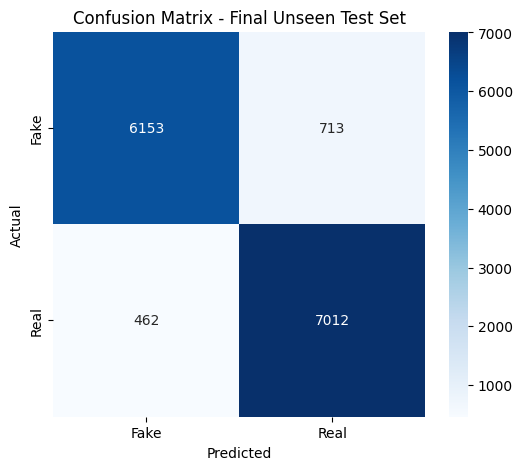

In [95]:
test_acc, test_loss = evaluate_model(best_model_loaded, X_test_final, y_test_final, "Final Unseen Test")

## Best Model Summary

In [96]:
print(f"\n--- Summary of Best Model Performance ---")
print(f"Training Accuracy:   {train_acc*100:.2f}% (Loss: {train_loss:.4f})")
print(f"Validation Accuracy: {val_acc*100:.2f}% (Loss: {val_loss:.4f})")
print(f"Test Accuracy:       {test_acc*100:.2f}% (Loss: {test_loss:.4f})")


--- Summary of Best Model Performance ---
Training Accuracy:   93.02% (Loss: 0.1577)
Validation Accuracy: 92.19% (Loss: 0.1877)
Test Accuracy:       91.81% (Loss: 0.1953)


## Plot Training History

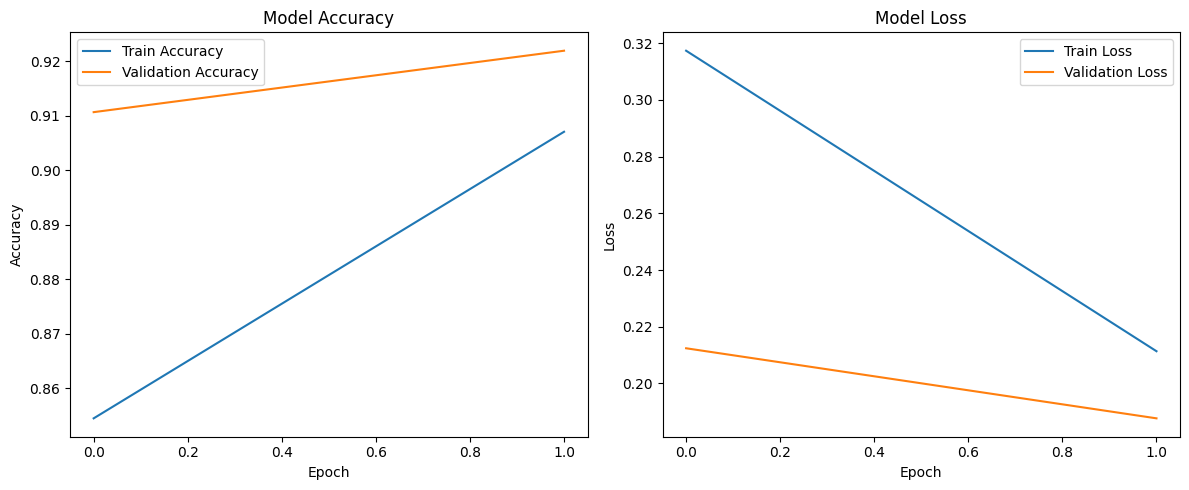


--- Process Complete ---
The 'best results' are the metrics printed above for the 'Final Unseen Test' data,
achieved after hyperparameter tuning with KerasTuner and training the best found model.
To achieve >85% on training and testing, observe the test accuracy: 91.81%.
If not met, you might need to: 
  - Ensure all your dataset paths are correct and datasets are loaded.
  - Use more diverse/larger datasets.
  - Increase `max_epochs` or `hyperband_iterations` in KerasTuner for a more thorough search.
  - Further refine the `build_bilstm_model` search space.
  - Experiment with different MAX_SEQUENCE_LENGTH or MAX_NUM_WORDS.


In [97]:
if history:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n--- Process Complete ---")
print("The 'best results' are the metrics printed above for the 'Final Unseen Test' data,")
print("achieved after hyperparameter tuning with KerasTuner and training the best found model.")
print(f"To achieve >85% on training and testing, observe the test accuracy: {test_acc*100:.2f}%.")
print("If not met, you might need to: ")
print("  - Ensure all your dataset paths are correct and datasets are loaded.")
print("  - Use more diverse/larger datasets.")
print("  - Increase `max_epochs` or `hyperband_iterations` in KerasTuner for a more thorough search.")
print("  - Further refine the `build_bilstm_model` search space.")
print("  - Experiment with different MAX_SEQUENCE_LENGTH or MAX_NUM_WORDS.")